# Regularization via Early Stopping, Adversarial Training, and Dropout

This notebook explores regularization in a two-layer MLP trained on the MNIST dataset. It
employs very basic early stopping via model caching, adversarial training via fast
adversarial sign generation, and a basic dropout implementation. Various models with the
different regularization techniques are trained on the MNIST dataset for 100 epochs. A
final model culiminates in all three regularization being employed. High level results
are: early stopping works well 

Prefacing results discussion with MNIST being a simple dataset, and our tested architecture
also being a basic feed forward netork, here the high level take-aways:

1. Early stopping works well, and the basic "U" shaped test loss is observed even when
only training a simple model to 100 epochs.

2. Adversarial training has a minimal effect on training loss compared to the full model
with no regularization. Plotting the adversarial examples shows samples largely being
populated with background noise, as oppose to small, unnoticeable perturbations, as seen
in the famous "Panda" example from the original paper.

3. Dropout on our simple model leads to severe underfitting, despite increasing the size of the model. However, reduced **test** loss compared to _train_ loss is observed. Dropout is
expected to increase training expense (Goodfellow et al., 2017), although the observed
loss in performance compared to other regularized models is still severe. More than others, the dropout model wants for hyper parameter optimization.

## Implementation

Implementation of the various methods were either performed in class found in `adversarial.py` 
(adversarial training, dropout) or in the `mixin.py` file in the root directory (early 
stopping).

#### Early Stopping

Early stopping is implemented using a basic model cacheing system, where the test loss is
evaluated after a specified number of training epochs. If the test loss is lower than the
previously measured value, the model is cached. Upon training completion, weights are set
to those contained by the cached model with the best test performance.


```python
def __early_stop_fit(
    self,
    training_loader: DataLoader,
    test_loader: DataLoader,
    verbose_step: int,
    step_size: int,
):
    best_loss = float("inf")
    self.test_loss_ = []
    self.test_loss_epochs_ = []
    with tempfile.TemporaryDirectory() as tmpdir:
        model_local = pathlib.Path(tmpdir).joinpath("model_checkpoint.pt")
        for t in range(self.n_epochs_):
            self.__batch_fit(
                data_loader=training_loader, batch_idx=t, verbose_step=verbose_step
            )
            self.__log_loss(
                epoch=t, print_loss=t == 0 or (t + 1) % verbose_step == 0
            )
            if (t % step_size) == 0:
                test_loss = self.test(test_loader)
                self.test_loss_.append(test_loss)
                self.test_loss_epochs_.append(t)
                if test_loss < best_loss:
                    best_loss = test_loss
                self.cache_model(model_local)
        self.load_saved_model(model_local)
```

#### Adversarial Training

Adversarial training uses a multi-objective loss function following fast adversarial sign
generation, as explained in [Goodfellow et al., 2015](https://arxiv.org/pdf/1412.6572).
That is:

$$ \hat J(\theta, x, y) = \alpha J(\theta, x, y) +
(1 - \alpha) J(\theta, x + \epsilon \text{sign} (\nabla_x J(\theta, x , y)), y) $$

This is implemented in a class-specific `__partial_fit()` method in `AdversarialMLP`

```python
def make_adversarial_examples(
    self, X: torch.Tensor, gradients: torch.Tensor
) -> torch.Tensor:
    return X + self.epsilon * gradients.sign()
    # return self.normalize_image_(X + self.epsilon * gradients.sign())

def __partial_fit(self, X, y):
    X.requires_grad = True
    main_loss = self.__calculate_loss(self(X), y)
    main_loss.backward()
    X_adv = self.make_adversarial_examples(X, X.grad.data)
    adversarial_loss = self.__calculate_loss(self(X_adv), y)

    loss = self.alpha * main_loss + (1 - self.alpha) * adversarial_loss
    loss.backward()
    self.optimizer.step()
    self.optimizer.zero_grad()
    return loss
```

#### Dropout

Dropout is perhaps the easiest to implement, as dropout layers are proved out of the box
using `torch.nn.Dropout`. In this case, we used a single dropout even in the neurons
connecting the two hidden layers.

```python
class DropOutMLP(MnistMLP):
    def __init__(
        self,
        rate: float = 1e-3,
        h1_size: int = 784,
        h2_size: int = 392,
        p_dropout_in=0.5,
        p_dropout_h=0.8,
    ):
        super().__init__(rate, h1_size, h2_size)
        self.mlp = nn.Sequential(
            nn.Linear(self.input_size_, h1_size),
            nn.ReLU(),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(),
            nn.Dropout(p=p_dropout_h),
            nn.Linear(h2_size, 10),
            nn.LogSoftmax(dim=1),  # Negative log-likelihood expects logged input
        )
```

## Set Up

In [1]:
import torch
from torch.utils.data import DataLoader
from sklearn import metrics
import numpy as np
import pathlib
from matplotlib import pyplot as plt

from adversarial import AdversarialMLP, DropOutMLP, AdversarialDropOut
from nets import MnistMLP, get_mnist

train_mnist = get_mnist(train=True)
test_mnist = get_mnist(train=False)

training_data = DataLoader(train_mnist, batch_size=64, shuffle=True)
test_data = DataLoader(test_mnist, batch_size=64, shuffle=True)

## Helper Functions

1. `get_fit_model()`
    - Train our models for N epochs or load previously saved models if the same model has already been trained. Fewer epochs were chosen to highlight differences between approaches.
2. `evaluate_model()`
    - Evaluate model on a provided data split using the Matthew's Correlation Coefficient and calculated loss.
3. `plot_early_stop()`
    - Plot train and test error throughout training, indicate epoch with the lowest test
    loss, and thus which iteration's weights were used in the final model.
4. `show_adversarial()`
    - Show the adversarial sample generated. Plots 3 columns of images: the original image,
    the generated adversary, and the difference between the two.

In [2]:
def get_fit_model(model, model_name, data_loader, fit_kwargs=None, force_train=False):
    if fit_kwargs is None:
        fit_kwargs = dict(n_epochs=100, verbose=True, verbose_step=10, track_loss=True)
    save_path = pathlib.Path("trained_models").joinpath(f"{model_name}.pt")
    if not save_path.parent.exists():
        save_path.parent.mkdir()
    if not save_path.exists() or force_train:
        print(f"No model found at {str(save_path)}. Fitting...")
        model.to(model.get_device())
        model.fit(data_loader, **fit_kwargs)
        print(f"Model fit, saving weights to {str(save_path)}.")
        torch.save(model, save_path)
    else:
        print("Previously trained model discovered, loading model.")
        model = torch.load(save_path)
    return model


In [3]:
def evaluate_model(model, data_loader, split):
    mccs = np.zeros(len(data_loader))
    loss = np.zeros(len(data_loader))
    model.eval()
    with torch.no_grad():
        for i, (X, y) in enumerate(data_loader):
            y_hat = model(X.to(model.get_device()))
            y_pred = y_hat.argmax(axis=1)
            loss[i] = model.loss(y_hat, y.to(model.get_device())).cpu().item()
            mccs[i] = metrics.matthews_corrcoef(y.cpu(), y_pred.cpu())
    print(f"Mean {split} MCC {mccs.mean():0.2f}, Mean loss: {loss.mean():0.7f}")
    return (mccs, loss)

In [4]:
def plot_early_stop(model, title):
    plt.axvline(
        x=model.test_loss_epochs_[np.argmin(model.test_loss_)],
        linestyle="--",
        color="black",
        label="Best epoch",
    )
    plt.scatter(model.epochs_, model.mean_loss_, label="train")
    plt.scatter(model.test_loss_epochs_, model.test_loss_, label="test", marker="x")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.title(title)


In [5]:
def show_adversarial(X, y, model, n_images=4):
    import torchvision.transforms.functional as F

    device = model.get_device()
    model.to(device)
    X = X.to(device)
    X.requires_grad = True
    loss = model.loss(model(X), y.to(device))
    loss.backward()
    X_adv = model.make_adversarial_examples(X, X.grad.data)
    imgs = [X[i, 0, :, :] for i in range(n_images)]
    adv_imgs = [X_adv[i, 0, :, :] for i in range(n_images)]
    fig, axs = plt.subplots(nrows=len(imgs), ncols=3, squeeze=False)
    fig.subplots_adjust(wspace=0, hspace=0)
    model.optimizer.zero_grad()

    def plot_image(img, ax):
        img = img.detach()
        img = F.to_pil_image(img)
        ax.imshow(np.asarray(img))
        ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    for i, img in enumerate(imgs):
        plot_image(img, axs[i, 0])
        plot_image(adv_imgs[i], axs[i, 1])
        plot_image(img - adv_imgs[i], axs[i, 2])
    plt.tight_layout()


## Full Model Training

In [6]:
full_model = MnistMLP(rate=0.01, h1_size=392, h2_size=196)
print(full_model)

MnistMLP(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
    (2): Linear(in_features=392, out_features=196, bias=True)
    (3): ReLU()
    (4): Linear(in_features=196, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
  (loss): NLLLoss()
)


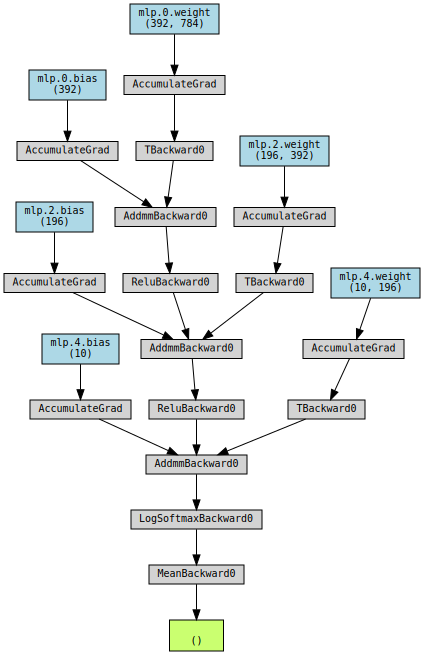

In [7]:
full_model.draw_network()

In [8]:
full_model.to(full_model.get_device())
fit_kwargs = dict(n_epochs=100, verbose_step=10, track_loss=True)


In [9]:
full_model = get_fit_model(
    full_model, "full_model", training_data, fit_kwargs=fit_kwargs, force_train=False
)


Previously trained model discovered, loading model.


Text(0.5, 1.0, 'Baseline mdoel - No regularization')

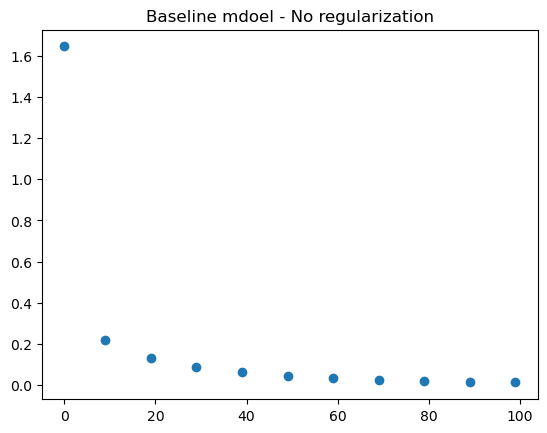

In [10]:
plt.scatter(full_model.epochs_, full_model.mean_loss_)
plt.title("Baseline mdoel - No regularization")


In [11]:
full_model_train_results = evaluate_model(full_model, training_data, "train")

Mean train MCC 1.00, Mean loss: 0.0108292


In [12]:
full_model_test_results = evaluate_model(full_model, test_data, "test")

Mean test MCC 0.98, Mean loss: 0.0636561


## Early Stopping: Full Model

In [13]:
full_model_es = MnistMLP(rate=0.01, h1_size=392, h2_size=196)
print(full_model_es)


MnistMLP(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
    (2): Linear(in_features=392, out_features=196, bias=True)
    (3): ReLU()
    (4): Linear(in_features=196, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
  (loss): NLLLoss()
)


In [14]:
early_stop_fit_kwargs = dict(
    n_epochs=100,
    verbose=True,
    verbose_step=10,
    track_loss=True,
    early_stopping=True,
    test_loader=test_data,
    early_step_size=1,
)
full_model_es = get_fit_model(
    full_model_es,
    "full_model_es",
    training_data,
    fit_kwargs=early_stop_fit_kwargs,
    force_train=False,
)


Previously trained model discovered, loading model.


Mean train MCC 1.00, Mean loss: 0.0108263


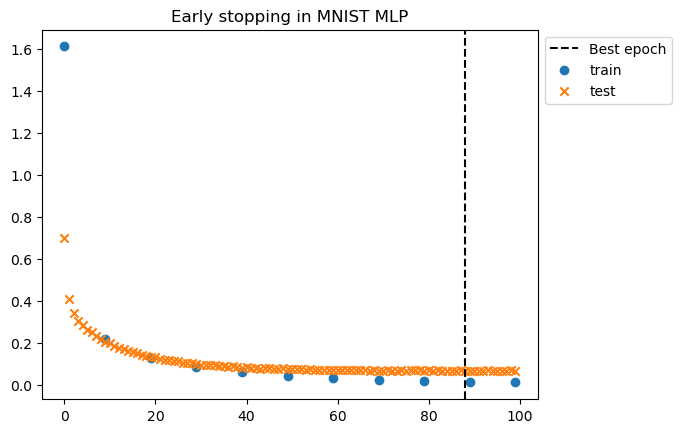

In [15]:
plot_early_stop(full_model_es, "Early stopping in MNIST MLP")
full_model_es_train_results = evaluate_model(full_model_es, training_data, "train")


In [16]:
full_model_es_test_results = evaluate_model(full_model_es, test_data, "test")

Mean test MCC 0.98, Mean loss: 0.0679026


## Adversarial Training

In [17]:
adv_model = AdversarialMLP(
    rate=0.01, h1_size=392, h2_size=196, epsilon=0.005, alpha=0.5
)
print(adv_model)


AdversarialMLP(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
    (2): Linear(in_features=392, out_features=196, bias=True)
    (3): ReLU()
    (4): Linear(in_features=196, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
  (loss): NLLLoss()
  (normalize_image_): Normalize(mean=0, std=1)
)


In [18]:
adv_model = get_fit_model(
    adv_model, "adv_model", training_data, fit_kwargs=fit_kwargs, force_train=False
)


Previously trained model discovered, loading model.


Text(0.5, 1.0, 'Full model with adversarial training')

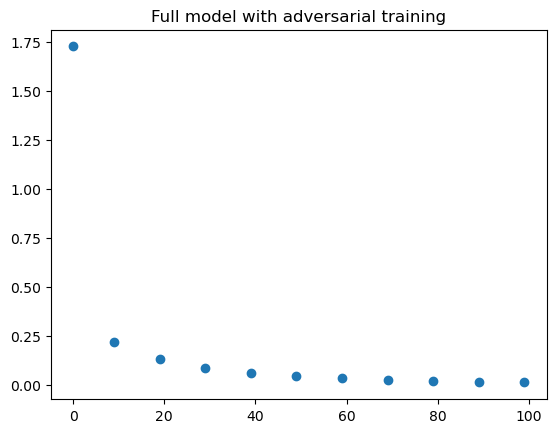

In [19]:
plt.scatter(adv_model.epochs_, adv_model.mean_loss_)
plt.title("Full model with adversarial training")


In [20]:
full_model_adv_train_results = evaluate_model(adv_model, training_data, "train")

Mean train MCC 1.00, Mean loss: 0.0110218


In [21]:
full_model_adv_test_results = evaluate_model(adv_model, test_data, "test")

Mean test MCC 0.98, Mean loss: 0.0629659


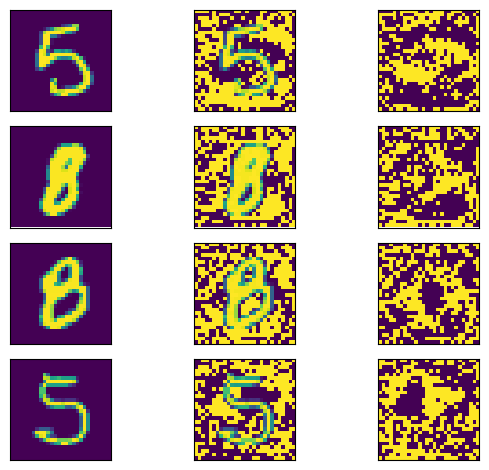

In [22]:
X, y = next(iter(test_data))
show_adversarial(X, y, adv_model, n_images=4)


## Adversarial with Early Stopping

In [23]:
adv_model_es = AdversarialMLP(
    rate=0.01, h1_size=392, h2_size=196, epsilon=0.005, alpha=0.5
)
print(adv_model_es)


AdversarialMLP(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
    (2): Linear(in_features=392, out_features=196, bias=True)
    (3): ReLU()
    (4): Linear(in_features=196, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
  (loss): NLLLoss()
  (normalize_image_): Normalize(mean=0, std=1)
)


In [24]:
adv_model_es = get_fit_model(
    adv_model_es,
    "adv_model_es",
    training_data,
    fit_kwargs=early_stop_fit_kwargs,
    force_train=False,
)


Previously trained model discovered, loading model.


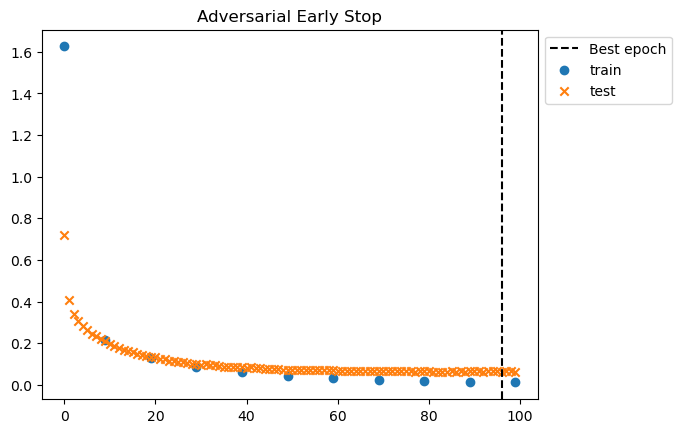

In [25]:
plot_early_stop(adv_model_es, "Adversarial Early Stop")

In [26]:
adv_model_es_train_results = evaluate_model(adv_model_es, training_data, "train")
adv_model_es_test_results = evaluate_model(adv_model_es, test_data, "test")


Mean train MCC 1.00, Mean loss: 0.0105751
Mean test MCC 0.98, Mean loss: 0.0638856


## Regularization via Dropout

In [33]:
dropout = DropOutMLP(
    rate=0.1, h1_size=784 * 2, h2_size=392 * 2, p_dropout_in=0.05, p_dropout_h=0.05
)
print(dropout)


DropOutMLP(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=1568, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1568, out_features=784, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.05, inplace=False)
    (5): Linear(in_features=784, out_features=10, bias=True)
    (6): LogSoftmax(dim=1)
  )
  (loss): NLLLoss()
)


In [36]:
dropout = get_fit_model(
    dropout,
    "dropout",
    training_data,
    fit_kwargs=early_stop_fit_kwargs,
    force_train=False,
)


No model found at trained_models\dropout.pt. Fitting...
Loss: 2.305127 [    1/  100]
Loss: 2.305173 [   10/  100]
Loss: 2.305168 [   20/  100]
Loss: 2.305172 [   30/  100]
Loss: 2.305174 [   40/  100]
Loss: 2.305165 [   50/  100]
Loss: 2.305175 [   60/  100]
Loss: 2.305172 [   70/  100]
Loss: 2.305170 [   80/  100]
Loss: 2.305171 [   90/  100]
Loss: 2.305165 [  100/  100]
Model fit, saving weights to trained_models\dropout.pt.


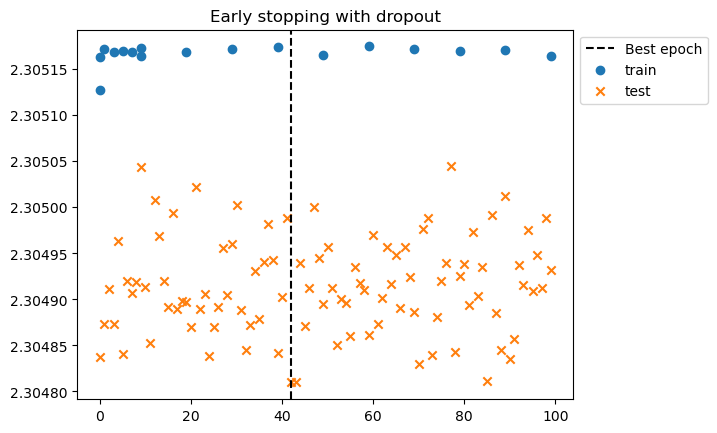

In [37]:
plot_early_stop(dropout, "Early stopping with dropout")

In [38]:
dropout_train_results = evaluate_model(dropout, training_data, "train")
dropout_test_results = evaluate_model(dropout, test_data, "test")


Mean train MCC -0.01, Mean loss: 2.3051686
Mean test MCC -0.01, Mean loss: 2.3048801


#### Adversarial with dropout



In [39]:
adv_dropout = AdversarialDropOut(
    rate=0.01,
    h1_size=784 * 2,
    h2_size=392 * 2,
    p_dropout_h=0.05,
    epsilon=0.004,
    alpha=0.5,
)
print(adv_dropout)


AdversarialDropOut(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=1568, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1568, out_features=784, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.05, inplace=False)
    (5): Linear(in_features=784, out_features=10, bias=True)
    (6): LogSoftmax(dim=1)
  )
  (loss): NLLLoss()
)


In [40]:
adv_dropout = get_fit_model(
    adv_dropout,
    "adv_dropout",
    training_data,
    fit_kwargs=early_stop_fit_kwargs,
    force_train=False,
)


No model found at trained_models\adv_dropout.pt. Fitting...
Loss: 2.306185 [    1/  100]
Loss: 2.306149 [   10/  100]
Loss: 2.306144 [   20/  100]
Loss: 2.306146 [   30/  100]
Loss: 2.306149 [   40/  100]
Loss: 2.306150 [   50/  100]
Loss: 2.306144 [   60/  100]
Loss: 2.306146 [   70/  100]
Loss: 2.306154 [   80/  100]
Loss: 2.306145 [   90/  100]
Loss: 2.306148 [  100/  100]
Model fit, saving weights to trained_models\adv_dropout.pt.


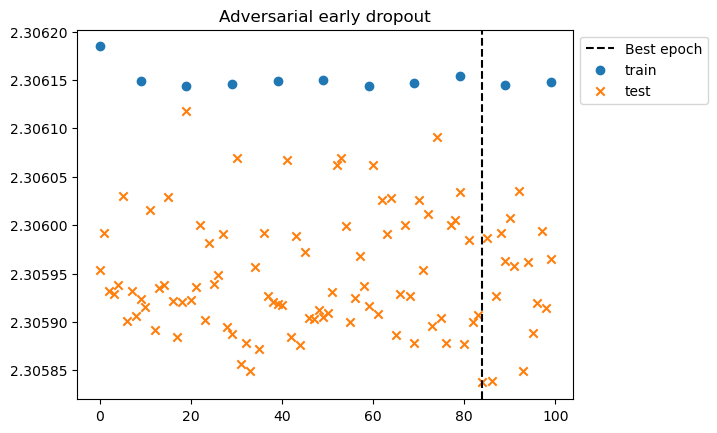

In [41]:
plot_early_stop(adv_dropout, "Adversarial early dropout")